Taking the g_train dataset (NB Test_Step_4, random seed 200, 80% of total dataset) and creating a stopwords list covering all music, and then three sets of words unique to each genre (Rock, Pop, Hip Hop).

This is a unique, nonproduction, lots-of-touch-labor kind of an operation.  Not putting together a code block for this one.

In [1]:
import s3fs

import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from tqdm.autonotebook import tqdm
tqdm.pandas(desc="progress-bar", leave=False)
import string

import spacy
from spacy.lang import punctuation
from spacy.lang.en import English
from spacy import displacy
nlp = spacy.load("en_core_web_lg")

import unicodedata  # might need to pip install unicodedate2 on aws sagemaker
import contractions
from contractions import contractions_dict ## pip installed this
from wordcloud import WordCloud, STOPWORDS #pip install
from textblob import TextBlob
!python -m textblob.download_corpora
from afinn import Afinn

import nltk
import nltk.corpus 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import ToktokTokenizer
from nltk.corpus import stopwords

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_string
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import word2vec
import multiprocessing as mp

import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings('ignore')
cores = mp.cpu_count()

import warnings
from datetime import datetime

warnings.filterwarnings('ignore')

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2',rc={'figure.figsize':(9,6),'figure.dpi':90})

punctuation = string.punctuation + '”' + '“' + '–' + '““' + "’’" + '”'
stopword = stopwords.words('english')
stopwords = set(STOPWORDS)
wordnet_lemmatizer = WordNetLemmatizer()

# Increase screen size.
#pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
pd.set_option('display.width', 1000)

%matplotlib inline
sns.set(style='darkgrid',palette='Dark2', rc={'figure.figsize':(9,6), 'figure.dpi':100})

<ipython-input-1-f09a7e3f74aa>:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


[nltk_data] Downloading package brown to /Users/Gretzky/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Gretzky/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Gretzky/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/Gretzky/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [2]:
fs = s3fs.S3FileSystem(anon=False,key='####',secret='####')

g_df = pd.read_csv('s3://music-lyrics-chain/g_train')

In [3]:
g_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69035 entries, 0 to 69034
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  69035 non-null  int64 
 1   song_name   69035 non-null  object
 2   lyrics      69035 non-null  object
 3   genre       69035 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.1+ MB


Text(0.5, 1.0, 'Distribution of classes in the genre variable')

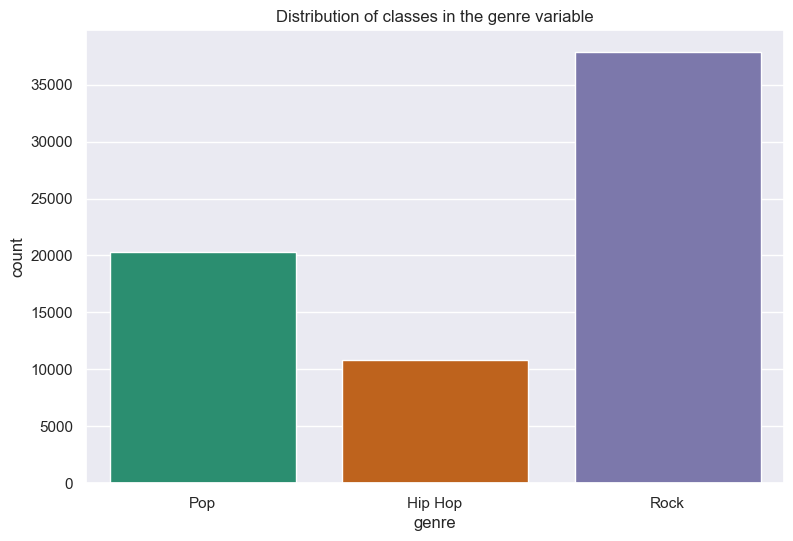

In [4]:
sns.countplot(x='genre', data=g_df).set_title('Distribution of classes in the genre variable')

In [ ]:
print("Current Time =", datetime.now())
val = int(input("How many words down do you want to go?\n"))
val2 = int(input("Size of the n in your n-gram?\n"))
val3 = bool(input("From most used to least used? Top to Bottom? True or False\n"))

def get_top_ngram(corpus, n=None, q=10):
    vec = CountVectorizer(ngram_range=(n, n),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=val3)
    #Can look at top or bottom of list changing that Bool.
    return words_freq[:q]

#genre_lista = g_df.genre.unique()
#genre_list = np.append(genre_lista, ['All'])
#genre_list = genre_list.insert(0,'All')
#genre_list = np.insert(genre_lista, 0, 'All')
#genre_list = ('Hip Hop', 'Pop', 'Rock', 'All')
genre_list = ('All','All')


print("Got it, ", val, val2, val3)
print(genre_list)

print("Current Time =", datetime.now())

n_gram_df = pd.DataFrame()
n = 0

for i in (genre_list):
	if i == 'All':
		word_list = get_top_ngram(g_df['lyrics'], val2, val) [:val]
		word_list_df = DataFrame (word_list, columns=[i, n])
		words_list = word_list_df[i].to_list()
		count_list = word_list_df[n].to_list()
		n_gram_df [i] = words_list
		n_gram_df [n] = count_list 
		print(i)
		print("Current Time =", datetime.now())
		n += 1
	else:
		g2_df = g_df[g_df['genre']== i]
		word_list = get_top_ngram(g2_df['lyrics'], val2, val) [:val]
		word_list_df = DataFrame (word_list, columns=[i, n])
		words_list = word_list_df[i].to_list()
		count_list = word_list_df[n].to_list()
		n_gram_df [i] = words_list
		n_gram_df [n] = count_list
		print(i)
		print("Current Time =", datetime.now())
		n += 1 

print("Current Time =", datetime.now())

print(n_gram_df)

In [ ]:
type(n_gram_df)

In [ ]:
all_words = pd.DataFrame((n_gram_df),columns=['All',0])
all_words.info()

In [ ]:
all_words[0].sum()

That number is 89% of the full data set number.  Meaning there are a lot of words in the other g_test 20%.

In [ ]:
all_words_least = all_words.copy()
all_words_least.drop(all_words_least[all_words_least[0]>36].index, inplace=True)
all_words_least.info()

In [ ]:
all_words_least[0].sum()

That means this all_words_least dataframe is the least used words in g_train that consititute less 5% of the toal words.

In [11]:
import os
import io
import boto3

from dotenv import load_dotenv
load_dotenv(verbose=True)

def aws_session(region_name='us-east-1'):
    return boto3.session.Session(aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'), #looks for any .env file
                                aws_secret_access_key=os.getenv('AWS_ACCESS_KEY_SECRET'), #Has to be in same directory
                                region_name=region_name) #from above

def make_bucket(name, acl): 
    session = aws_session()
    s3_resource = session.resource('s3')
    return s3_resource.create_bucket(Bucket=name, ACL=acl)

def upload_file_to_bucket(bucket_name, file_path):
    session = aws_session()
    s3_resource = session.resource('s3')
    file_dir, file_name = os.path.split(file_path)

    bucket = s3_resource.Bucket(bucket_name)
    bucket.upload_file(
      Filename=file_path,
      Key=file_name,
      ExtraArgs={'ACL': 'public-read'}
    )

    s3_url = f"https://{bucket_name}.s3.amazonaws.com/{file_name}"
    return s3_url

In [ ]:
all_words_least.to_csv('g_stopwords')

upload_file_to_bucket('music-lyrics-chain','g_stopwords')

In [ ]:
g_stopwords

In [ ]:
all_words.to_csv('g_words')

upload_file_to_bucket('music-lyrics-chain','g_words')

Step one: For each genre, get all of the words.

In [5]:
print("Current Time =", datetime.now())
val = int(input("How many words down do you want to go?\n"))
val2 = int(input("Size of the n in your n-gram?\n"))
val3 = bool(input("From most used to least used? Top to Bottom? True or False\n"))

def get_top_ngram(corpus, n=None, q=10):
    vec = CountVectorizer(ngram_range=(n, n),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=val3)
    #Can look at top or bottom of list changing that Bool.
    return words_freq[:q]

#genre_lista = g_df.genre.unique()
#genre_list = np.append(genre_lista, ['All'])
#genre_list = genre_list.insert(0,'All')
#genre_list = np.insert(genre_lista, 0, 'All')
#genre_list = ('Hip Hop', 'Pop', 'Rock', 'All')
genre_list = ('Hip Hop','Hip Hop')


print("Got it, ", val, val2, val3)
print(genre_list)

print("Current Time =", datetime.now())

n_gram_df = pd.DataFrame()
n = 0

for i in (genre_list):
	if i == 'All':
		word_list = get_top_ngram(g_df['lyrics'], val2, val) [:val]
		word_list_df = DataFrame (word_list, columns=[i, n])
		words_list = word_list_df[i].to_list()
		count_list = word_list_df[n].to_list()
		n_gram_df [i] = words_list
		n_gram_df [n] = count_list 
		print(i)
		print("Current Time =", datetime.now())
		n += 1
	else:
		g2_df = g_df[g_df['genre']== i]
		word_list = get_top_ngram(g2_df['lyrics'], val2, val) [:val]
		word_list_df = DataFrame (word_list, columns=[i, n])
		words_list = word_list_df[i].to_list()
		count_list = word_list_df[n].to_list()
		n_gram_df [i] = words_list
		n_gram_df [n] = count_list
		print(i)
		print("Current Time =", datetime.now())
		n += 1 

print("Current Time =", datetime.now())

print(n_gram_df)

Current Time = 2021-05-29 16:02:36.156797
How many words down do you want to go?
100000
Size of the n in your n-gram?
1
From most used to least used? Top to Bottom? True or False
True
Got it,  100000 1 True
('Hip Hop', 'Hip Hop')
Current Time = 2021-05-29 16:02:49.730266
Hip Hop
Current Time = 2021-05-29 16:02:55.142095
Hip Hop
Current Time = 2021-05-29 16:03:00.433118
Current Time = 2021-05-29 16:03:00.433233


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
n_gram_df.head(100)

,Hip Hop,0,1
0,like,46642,46642
1,got,35368,35368
2,know,33244,33244
3,don,32809,32809
4,just,25822,25822
5,ain,21722,21722
6,nigga,20765,20765
7,love,19968,19968
8,yeah,18635,18635
9,let,17348,17348


In [10]:
hiphop_words = pd.DataFrame((n_gram_df),columns=['Hip Hop',0])
hiphop_words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64406 entries, 0 to 64405
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Hip Hop  64406 non-null  object
 1   0        64406 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1006.5+ KB


In [12]:
hiphop_words.to_csv('hiphop_words')

upload_file_to_bucket('music-lyrics-chain','hiphop_words')

'https://music-lyrics-chain.s3.amazonaws.com/hiphop_words'

In [13]:
print("Current Time =", datetime.now())
val = int(input("How many words down do you want to go?\n"))
val2 = int(input("Size of the n in your n-gram?\n"))
val3 = bool(input("From most used to least used? Top to Bottom? True or False\n"))

def get_top_ngram(corpus, n=None, q=10):
    vec = CountVectorizer(ngram_range=(n, n),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=val3)
    #Can look at top or bottom of list changing that Bool.
    return words_freq[:q]

#genre_lista = g_df.genre.unique()
#genre_list = np.append(genre_lista, ['All'])
#genre_list = genre_list.insert(0,'All')
#genre_list = np.insert(genre_lista, 0, 'All')
#genre_list = ('Hip Hop', 'Pop', 'Rock', 'All')
genre_list = ('Rock','Rock')


print("Got it, ", val, val2, val3)
print(genre_list)

print("Current Time =", datetime.now())

n_gram_df = pd.DataFrame()
n = 0

for i in (genre_list):
	if i == 'All':
		word_list = get_top_ngram(g_df['lyrics'], val2, val) [:val]
		word_list_df = DataFrame (word_list, columns=[i, n])
		words_list = word_list_df[i].to_list()
		count_list = word_list_df[n].to_list()
		n_gram_df [i] = words_list
		n_gram_df [n] = count_list 
		print(i)
		print("Current Time =", datetime.now())
		n += 1
	else:
		g2_df = g_df[g_df['genre']== i]
		word_list = get_top_ngram(g2_df['lyrics'], val2, val) [:val]
		word_list_df = DataFrame (word_list, columns=[i, n])
		words_list = word_list_df[i].to_list()
		count_list = word_list_df[n].to_list()
		n_gram_df [i] = words_list
		n_gram_df [n] = count_list
		print(i)
		print("Current Time =", datetime.now())
		n += 1 

print("Current Time =", datetime.now())

print(n_gram_df)

Current Time = 2021-05-29 16:07:04.333189
How many words down do you want to go?
100000
Size of the n in your n-gram?
1
From most used to least used? Top to Bottom? True or False
True
Got it,  100000 1 True
('Rock', 'Rock')
Current Time = 2021-05-29 16:07:11.412402
Rock
Current Time = 2021-05-29 16:07:18.716379
Rock
Current Time = 2021-05-29 16:07:26.296002
Current Time = 2021-05-29 16:07:26.296132


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [14]:
rock_words = pd.DataFrame((n_gram_df),columns=['Rock',0])
rock_words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57496 entries, 0 to 57495
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Rock    57496 non-null  object
 1   0       57496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 898.5+ KB


In [15]:
rock_words.head(20)

,Rock,0
0,don,52511
1,love,43442
2,know,43362
3,just,40292
4,ll,37227
5,like,35838
6,oh,35330
7,got,29389
8,ve,28977
9,time,28532


In [16]:
rock_words.to_csv('rock_words')

upload_file_to_bucket('music-lyrics-chain','rock_words')

'https://music-lyrics-chain.s3.amazonaws.com/rock_words'

In [17]:
print("Current Time =", datetime.now())
val = int(input("How many words down do you want to go?\n"))
val2 = int(input("Size of the n in your n-gram?\n"))
val3 = bool(input("From most used to least used? Top to Bottom? True or False\n"))

def get_top_ngram(corpus, n=None, q=10):
    vec = CountVectorizer(ngram_range=(n, n),stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=val3)
    #Can look at top or bottom of list changing that Bool.
    return words_freq[:q]

#genre_lista = g_df.genre.unique()
#genre_list = np.append(genre_lista, ['All'])
#genre_list = genre_list.insert(0,'All')
#genre_list = np.insert(genre_lista, 0, 'All')
#genre_list = ('Hip Hop', 'Pop', 'Rock', 'All')
genre_list = ('Pop','Pop')


print("Got it, ", val, val2, val3)
print(genre_list)

print("Current Time =", datetime.now())

n_gram_df = pd.DataFrame()
n = 0

for i in (genre_list):
	if i == 'All':
		word_list = get_top_ngram(g_df['lyrics'], val2, val) [:val]
		word_list_df = DataFrame (word_list, columns=[i, n])
		words_list = word_list_df[i].to_list()
		count_list = word_list_df[n].to_list()
		n_gram_df [i] = words_list
		n_gram_df [n] = count_list 
		print(i)
		print("Current Time =", datetime.now())
		n += 1
	else:
		g2_df = g_df[g_df['genre']== i]
		word_list = get_top_ngram(g2_df['lyrics'], val2, val) [:val]
		word_list_df = DataFrame (word_list, columns=[i, n])
		words_list = word_list_df[i].to_list()
		count_list = word_list_df[n].to_list()
		n_gram_df [i] = words_list
		n_gram_df [n] = count_list
		print(i)
		print("Current Time =", datetime.now())
		n += 1 

print("Current Time =", datetime.now())

print(n_gram_df)

Current Time = 2021-05-29 16:10:09.621440
How many words down do you want to go?
100000
Size of the n in your n-gram?
1
From most used to least used? Top to Bottom? True or False
True
Got it,  100000 1 True
('Pop', 'Pop')
Current Time = 2021-05-29 16:10:15.723232
Pop
Current Time = 2021-05-29 16:10:20.983844
Pop
Current Time = 2021-05-29 16:10:26.077756
Current Time = 2021-05-29 16:10:26.077868


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [18]:
n_gram_df.head(20)

,Pop,0,1
0,love,49089,49089
1,don,45462,45462
2,oh,43967,43967
3,know,41600,41600
4,like,37362,37362
5,just,34913,34913
6,ll,27505,27505
7,baby,26319,26319
8,got,25833,25833
9,let,24729,24729


In [19]:
pop_words = pd.DataFrame((n_gram_df),columns=['Pop',0])
pop_words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45426 entries, 0 to 45425
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Pop     45426 non-null  object
 1   0       45426 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 709.9+ KB


In [20]:
pop_words.to_csv('pop_words')

upload_file_to_bucket('music-lyrics-chain','pop_words')

'https://music-lyrics-chain.s3.amazonaws.com/pop_words'

Step Two: Compare each list against each list one by one.  This will create six lists of words.  Pop through rock, hiphop through pop, etc.  Using a union of unions to pd.concat out the common words.

In [21]:
hiphop2_df = hiphop_words.rename(columns={'Hip Hop':'Word','0':'Count'})
pop2_df = pop_words.rename(columns={'Pop':'Word','0':'Count'})

#outer join (keeps all data), joined on hihop 'Word' (longest list), indicator=Ture
#will tell me what word is where.

hiphopandpop = pd.merge(hiphop2_df, pop2_df, on="Word", how="outer", indicator=True)

In [23]:
hiphopandpop.head(20)

,Word,0_x,0_y,_merge
0,like,46642.0,37362.0,both
1,got,35368.0,25833.0,both
2,know,33244.0,41600.0,both
3,don,32809.0,45462.0,both
4,just,25822.0,34913.0,both
5,ain,21722.0,9575.0,both
6,nigga,20765.0,733.0,both
7,love,19968.0,49089.0,both
8,yeah,18635.0,22165.0,both
9,let,17348.0,24729.0,both


In [24]:
hiphopandpop.groupby(['_merge']).count()

,Word,0_x,0_y
_merge,,,
left_only,37476,37476,0
right_only,18496,0,18496
both,26930,26930,26930


In [25]:
hiphopandpop.drop(hiphopandpop[hiphopandpop['_merge']=='both'].index, inplace=True)
hiphopandpop.groupby(['_merge']).count()

,Word,0_x,0_y
_merge,,,
left_only,37476,37476,0
right_only,18496,0,18496
both,0,0,0


In [27]:
hiphop_copy = hiphopandpop.copy()
pop_copy = hiphopandpop.copy()

In [28]:
pop_copy.drop(pop_copy[pop_copy['_merge']=='left_only'].index, inplace=True)
pop_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18496 entries, 64406 to 82901
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   Word    18496 non-null  object  
 1   0_x     0 non-null      float64 
 2   0_y     18496 non-null  float64 
 3   _merge  18496 non-null  category
dtypes: category(1), float64(2), object(1)
memory usage: 596.2+ KB


In [30]:
pop_copy.drop(columns=['0_x','_merge'], inplace=True)
pop_copy.describe(include='all')

,Word,0_y
count,18496,18496.000000
unique,18496,NaN
top,atracao,NaN
freq,1,NaN
mean,NaN,2.213452
std,NaN,3.940880
min,NaN,1.000000
25%,NaN,1.000000
50%,NaN,1.000000
75%,NaN,2.000000


In [31]:
pop_thru_hiphop = pop_copy.rename(columns={'Word':'Word','0_y':'Count'})
pop_thru_hiphop.head()

,Word,Count
64406,pressurin,112.0
64407,badoom,104.0
64408,yoü,101.0
64409,oppa,97.0
64410,phresh,91.0


In [32]:
pop_thru_hiphop.to_csv('pop_thru_hiphop')

upload_file_to_bucket('music-lyrics-chain','pop_thru_hiphop')

'https://music-lyrics-chain.s3.amazonaws.com/pop_thru_hiphop'

In [33]:
hiphop_copy.drop(hiphop_copy[hiphop_copy['_merge']=='right_only'].index, inplace=True)
hiphop_copy.drop(columns=['0_y','_merge'], inplace=True)
hiphop_thru_pop = hiphop_copy.rename(columns={'Word':'Word','0_x':'Count'})

In [34]:
hiphop_thru_pop.head()

,Word,Count
925,xzibit,418.0
1636,omarion,220.0
1745,loc,202.0
1888,wala,181.0
2529,kuniva,122.0


In [35]:
hiphop_thru_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37476 entries, 925 to 64405
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Word    37476 non-null  object 
 1   Count   37476 non-null  float64
dtypes: float64(1), object(1)
memory usage: 878.3+ KB


In [36]:
hiphop_thru_pop.to_csv('hiphop_thru_pop')

upload_file_to_bucket('music-lyrics-chain','hiphop_thru_pop')

'https://music-lyrics-chain.s3.amazonaws.com/hiphop_thru_pop'

In [38]:
rock2_df = rock_words.rename(columns={'Rock':'Word','0':'Count'})
hiphopandrock = pd.merge(hiphop2_df, rock2_df, on="Word", how="outer", indicator=True)
hiphopandrock.groupby(['_merge']).count()

,Word,0_x,0_y
_merge,,,
left_only,34740,34740,0
right_only,27830,0,27830
both,29666,29666,29666


In [40]:
#Drop words in both genres by: 
hiphopandrock.drop(hiphopandrock[hiphopandrock['_merge']=='both'].index, inplace=True)
hiphopandrock.groupby(['_merge']).count()

,Word,0_x,0_y
_merge,,,
left_only,34740,34740,0
right_only,27830,0,27830
both,0,0,0


In [41]:
hiphop_copy = hiphopandrock.copy()
rock_copy = hiphopandrock.copy()

In [42]:
#get rid of rock, re-name.
hiphop_copy.drop(hiphop_copy[hiphop_copy['_merge']=='right_only'].index, inplace=True)
hiphop_copy.drop(columns=['0_y','_merge'], inplace=True)
hiphop_thru_rock = hiphop_copy.rename(columns={'Word':'Word','0_x':'Count'})
hiphop_thru_rock.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34740 entries, 536 to 64405
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Word    34740 non-null  object 
 1   Count   34740 non-null  float64
dtypes: float64(1), object(1)
memory usage: 814.2+ KB


In [43]:
hiphop_thru_rock.to_csv('hiphop_thru_rock')

upload_file_to_bucket('music-lyrics-chain','hiphop_thru_rock')

'https://music-lyrics-chain.s3.amazonaws.com/hiphop_thru_rock'

In [44]:
#get rid of hip hop, re-name.
rock_copy.drop(rock_copy[rock_copy['_merge']=='left_only'].index, inplace=True)
rock_copy.drop(columns=['0_x','_merge'], inplace=True)
rock_thru_hiphop = rock_copy.rename(columns={'Word':'Word','0_y':'Count'})
rock_thru_hiphop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27830 entries, 64406 to 92235
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Word    27830 non-null  object 
 1   Count   27830 non-null  float64
dtypes: float64(1), object(1)
memory usage: 652.3+ KB


In [45]:
rock_thru_hiphop.to_csv('rock_thru_hiphop')

upload_file_to_bucket('music-lyrics-chain','rock_thru_hiphop')

'https://music-lyrics-chain.s3.amazonaws.com/rock_thru_hiphop'

In [46]:
rockandpop = pd.merge(rock2_df, pop2_df, on="Word", how="outer", indicator=True)
rockandpop.groupby(['_merge']).count()

,Word,0_x,0_y
_merge,,,
left_only,30724,30724,0
right_only,18654,0,18654
both,26772,26772,26772


In [47]:
rockandpop.drop(rockandpop[rockandpop['_merge']=='both'].index, inplace=True)
rockandpop.groupby(['_merge']).count()

,Word,0_x,0_y
_merge,,,
left_only,30724,30724,0
right_only,18654,0,18654
both,0,0,0


In [48]:
rock_copy = rockandpop.copy()
pop_copy = rockandpop.copy()

#get rid of pop, re-name.
rock_copy.drop(rock_copy[rock_copy['_merge']=='right_only'].index, inplace=True)
rock_copy.drop(columns=['0_y','_merge'], inplace=True)
rock_thru_pop = rock_copy.rename(columns={'Word':'Word','0_x':'Count'})

In [49]:
rock_thru_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30724 entries, 1887 to 57495
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Word    30724 non-null  object 
 1   Count   30724 non-null  float64
dtypes: float64(1), object(1)
memory usage: 720.1+ KB


In [50]:
rock_thru_pop.head()

,Word,Count
1887,diddley,222.0
2238,richards,169.0
2447,zevon,149.0
2760,blondie,126.0
2805,a5,122.0


In [51]:
#get rid of rock, re-name.
pop_copy.drop(pop_copy[pop_copy['_merge']=='left_only'].index, inplace=True)
pop_copy.drop(columns=['0_x','_merge'], inplace=True)
pop_thru_rock = pop_copy.rename(columns={'Word':'Word','0_y':'Count'})
pop_thru_rock.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18654 entries, 57496 to 76149
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Word    18654 non-null  object 
 1   Count   18654 non-null  float64
dtypes: float64(1), object(1)
memory usage: 437.2+ KB


In [52]:
rock_thru_pop.to_csv('rock_thru_pop')
pop_thru_rock.to_csv('pop_thru_rock')

upload_file_to_bucket('music-lyrics-chain','rock_thru_pop')
upload_file_to_bucket('music-lyrics-chain','pop_thru_rock')

'https://music-lyrics-chain.s3.amazonaws.com/pop_thru_rock'

Step Three: pd.concat the genre_thru_other and genre_thru_other other.  The _both group is unique to that genre.

In [53]:
rock_n_rock = pd.merge(rock_thru_pop, rock_thru_hiphop, on="Word", how="outer", indicator=True)
rock_n_rock.groupby(['_merge']).count()

,Word,Count_x,Count_y
_merge,,,
left_only,7633,7633,0
right_only,4739,0,4739
both,23091,23091,23091


In [54]:
rock_n_rock.drop(rock_n_rock[rock_n_rock['_merge']=='right_only'].index, inplace=True)
rock_n_rock.drop(rock_n_rock[rock_n_rock['_merge']=='left_only'].index, inplace=True)

rock_n_rock.groupby(['_merge']).count()

,Word,Count_x,Count_y
_merge,,,
left_only,0,0,0
right_only,0,0,0
both,23091,23091,23091


In [56]:
rock_n_rock.to_csv('uniquely_rock')

upload_file_to_bucket('music-lyrics-chain','uniquely_rock')

'https://music-lyrics-chain.s3.amazonaws.com/uniquely_rock'

In [57]:
hh_n_hh = pd.merge(hiphop_thru_rock, hiphop_thru_pop, on="Word", how="outer", indicator=True)
hh_n_hh.groupby(['_merge']).count()

,Word,Count_x,Count_y
_merge,,,
left_only,4897,4897,0
right_only,7633,0,7633
both,29843,29843,29843


In [58]:
hh_n_hh.drop(hh_n_hh[hh_n_hh['_merge']=='right_only'].index, inplace=True)
hh_n_hh.drop(hh_n_hh[hh_n_hh['_merge']=='left_only'].index, inplace=True)

hh_n_hh.groupby(['_merge']).count()

,Word,Count_x,Count_y
_merge,,,
left_only,0,0,0
right_only,0,0,0
both,29843,29843,29843


In [59]:
hh_n_hh.to_csv('uniquely_hiphop')

upload_file_to_bucket('music-lyrics-chain','uniquely_hiphop')

'https://music-lyrics-chain.s3.amazonaws.com/uniquely_hiphop'

In [60]:
pop_n_pop = pd.merge(pop_thru_rock, pop_thru_hiphop, on="Word", how="outer", indicator=True)
pop_n_pop.groupby(['_merge']).count()

,Word,Count_x,Count_y
_merge,,,
left_only,4897,4897,0
right_only,4739,0,4739
both,13757,13757,13757


In [61]:
pop_n_pop.drop(pop_n_pop[pop_n_pop['_merge']=='right_only'].index, inplace=True)
pop_n_pop.drop(pop_n_pop[pop_n_pop['_merge']=='left_only'].index, inplace=True)

pop_n_pop.groupby(['_merge']).count()

,Word,Count_x,Count_y
_merge,,,
left_only,0,0,0
right_only,0,0,0
both,13757,13757,13757


In [62]:
pop_n_pop.to_csv('uniquely_pop')

upload_file_to_bucket('music-lyrics-chain','uniquely_pop')

'https://music-lyrics-chain.s3.amazonaws.com/uniquely_pop'